# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
# Imports here
import os
from collections import OrderedDict
import json

import numpy as np
import torch
import torch.nn.functional as tf
import torchvision as tv

from PIL import Image

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
data_dir = 'flowers'
names = ['train', 'valid', 'test']

dataset = {
    name: os.path.join(data_dir, name) for name in names
}

In [3]:
# Utility functions.

def get_crop_size():
    """ Return crop size for ImageNet images.
    """
    return (224, 224)

def get_image_mean():
    """ Return collection of mean values for color channels
        of ImageNet images.
    """
    return [0.485, 0.456, 0.406]

def get_image_std():
    """ Return collection of deviation values for color channels
        of ImageNet images.
    """
    return [0.229, 0.224, 0.225]

In [4]:
# TODO: Define your transforms for the training, validation, and testing sets
crop_width, _ = get_crop_size()
data_transforms = {
    'train': tv.transforms.Compose([
                tv.transforms.RandomRotation(20),
                tv.transforms.RandomResizedCrop(crop_width),
                tv.transforms.RandomHorizontalFlip(0.5),
                tv.transforms.ToTensor(),
                tv.transforms.Normalize(get_image_mean(), get_image_std())
    
    ]),

    'valid': tv.transforms.Compose([
                    tv.transforms.Resize(256),
                    tv.transforms.CenterCrop(crop_width),
                    tv.transforms.ToTensor(),
                    tv.transforms.Normalize(get_image_mean(), get_image_std())
                ]),
    
    'test': tv.transforms.Compose([
                tv.transforms.Resize(256),
                tv.transforms.CenterCrop(crop_width),
                tv.transforms.ToTensor(),
                tv.transforms.Normalize(get_image_mean(), get_image_std())    
            ])
}

# TODO: Load the datasets with ImageFolder
image_datasets = {
    name : tv.datasets.ImageFolder(dataset[name], 
                                   transform=data_transforms[name]) for name in names
}

# TODO: Using the image datasets and the trainforms, define the dataloaders
dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=96, shuffle=True),
    'valid': torch.utils.data.DataLoader(image_datasets['valid'], batch_size=32, shuffle=True),
    'test':  torch.utils.data.DataLoader(image_datasets['test'], batch_size=32, shuffle=False)
}    

def class_to_index():
    """ Return dictionary that maps target class to target index.
    """
    return dataloaders['train'].dataset.class_to_idx

def get_batch_size():
    """ Return batch size of train data set.
    """
    images, _ = next(iter(dataloaders['train']))
    return images.shape[0]

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [5]:
def category_to_name():
    """ Return dictionary for category/class to name lookup.
    """
    with open('cat_to_name.json', 'r') as f:
        return json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

#### Define function that serves as a pre-trained model factory: get pre-trained model by name.

In [6]:
# Load model pre-trained on ImageNet
def pretrained_model_factory(arch):
    """ Return vgg19 pre-trained model
    """
    if arch == 'vgg19':
        return lambda: tv.models.vgg19(pretrained=True)
    else:
        raise Exception('Unknown architecture: {}'.format(arch))

#### Define function that makes neural network classifier model based on specified pre-trained model.

In [7]:
# Define network model to use as a classifier for problem domain.
def make_model(pretrained_model_factory, output_size, hidden_layers, drop_prob=0.3):
    """
    Return model with classifier for the problem domain.
    """
    def make_classifier_net(input_size, output_size, hidden_layers, dropout=0.3):
        """
        Return instance of torch.nn.Sequential class
        """
        layers = [input_size] + hidden_layers + [output_size]
        input_output_size = [] 
        for x, y in zip(layers[:-1], layers[1:]):
            input_output_size.append((x, y))

        modules = []
        for i, (inp_size, out_size) in enumerate(input_output_size[:-1]):
            modules.append(("fc{}".format(i), torch.nn.Linear(inp_size, out_size)))
            modules.append(("relu{}".format(i), torch.nn.ReLU()))
            modules.append(("dropout{}".format(i), torch.nn.Dropout(dropout)))
        # Add output layer
        inp_size, out_size = input_output_size[-1]
        modules.append(("fc-output", torch.nn.Linear(inp_size, out_size)))
        modules.append(("logsoftmax", torch.nn.LogSoftmax(dim=1)))

        seq = torch.nn.Sequential(OrderedDict(modules))
        return seq   

    model = pretrained_model_factory()
    for param in model.parameters():
        param.requires_grad = False

    input_size = model.classifier[0].in_features
    model.classifier = make_classifier_net(input_size, output_size, hidden_layers, drop_prob)
    return model

#### Define function to train neural network and to evaluate neural network performance.

In [8]:
# Define validation and training functions.

def train(model, device, dataloader, criterion, optimizer, lr_monitor=None):
    """
    Return 
        mean train loss over all iteration of the current epoch.
    """
    train_loss = []
    for x, y in iter(dataloader):
        model.train()
        optimizer.zero_grad()
        x, y = x.to(device), y.to(device)
        y_hat = model(x)        
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
        if lr_monitor is not None:
            lr_monitor()
    return np.mean(train_loss)

def loss_accuracy_score(model, device, dataloader, criterion):
    """
    Return pair (loss, accuracy) for specified data set.
    Loss and accuracy are averaged over batches.
    """
    loss = 0
    accuracy = 0
    dataloader = iter(dataloader)
    N = len(dataloader)
    
    model.eval()
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            y_hat = model.forward(x)
            loss += criterion(y_hat, y).item()
            probs = torch.exp(y_hat)
            accuracy += (y.data == probs.max(dim=1)[1]).type(torch.FloatTensor).mean()    
    return float(loss) / N, accuracy / N

def accuracy_score(model, device, dataloader):
    """
    Return model accuracy on specified data set.
    """
    accuracy = 0
    dataloader = iter(dataloader)
    N = len(dataloader)
    
    model.eval()
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            y_hat = model.forward(x)
            probs = torch.exp(y_hat)
            accuracy += (y.data == probs.max(dim=1)[1]).type(torch.FloatTensor).mean()
    return accuracy / N

#### Define function that implements training process and returns reference to a best model's checkpoint.

In [9]:
# Train network API            
def train_network(device,
                  model_factory, 
                  criterion_factory,
                  classifier_descriptor,
                  epochs_per_cycle,
                  num_cycles, 
                  max_learning_rate,
                  dumping_koeff=1.0,
                  momentum=0.8): 
    """ Train neural net model with adjustable learning rate.
        Cosine annealing policy is used to control learning rate value.
        
        Return:
            - Neural Net model.
            - Performance report.
            
        Parameters
        ----------
        device                   ::= 'cuda' or 'cpu'
        model_factory            ::= factory function, returns pre-trained model + classifier
        criterion_factory        ::= factory function, returns instance of a criterion / loss class.
        classifier_descriptor    ::= dictionary, describes parameters of classifier network.
        # parameters that control learning rate schedule
        epochs_per_cycle         ::= number of epochs per learning rate adjustment cycle
        num_cycles               ::= number of cycles to train network for. Total epochs = num_cycles * epochs_per_cycle
        max_learning_rate        ::= max learning rate 
        dumping_koeff            ::= Next cycle's max learning rate = curr cycle max learning rate x dumping koeff.  
    """
    model = model_factory()                       
    model.to(device)    
    criterion = criterion_factory() 
    optimizer = torch.optim.SGD(model.classifier.parameters(), 
                                lr=max_learning_rate, 
                                momentum=momentum)

    num_batches = len(dataloaders['train']) # number of batches per epoch.
    T = epochs_per_cycle * num_batches # num iterations per cosine annealing cycle.
    epochs = epochs_per_cycle * num_cycles
    print("n={} epochs={} num-iter-per-epoch={} num-iter-per-cycle={}".format(num_batches*get_batch_size(), epochs, num_batches, T))
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T)
    
    learn_rate_monitor = LearnRateMonitor(lr_scheduler)
    learning_rate = max_learning_rate
    perf_report = []
    
    for epoch_no in range(1, epochs + 1):
        train_loss = train(model, device, dataloaders['train'], criterion, optimizer, learn_rate_monitor)
        # Compute model performance on validation data set.
        valid_loss, valid_acc = loss_accuracy_score(model, device, dataloaders['valid'], criterion)
        perf_report.append({'train-loss': train_loss,
                            'valid-loss': valid_loss,
                            'valid-acc': valid_acc})        
        print("*** Epoch {} of {} ".format(epoch_no, epochs),
                  "Training Loss: {:.3f}.. ".format(train_loss),
                  "Valid loss: {:.3f}..".format(valid_loss),
                  "Valid acc: {:.3f}..".format(valid_acc))
        # Reset learning rate for next cycle to max_learning_rate * dumping_koeff
        if epoch_no % epochs_per_cycle == 0:        
            learning_rate = learning_rate * dumping_koeff
            optimizer = torch.optim.SGD(model.classifier.parameters(), lr=learning_rate, momentum=momentum)
            learn_rate_monitor.lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T)
    return model, perf_report

class LearnRateMonitor(object):
    """ LearnRateMonitor monitors training process:
        - adjust learning rate.
    """
    def __init__(self, lr_scheduler):
        """
            Parameters
            ----------
            @lr_scheduler::= learning rate scheduler
        """
        self.lr_scheduler_ = lr_scheduler
    
    @property
    def lr_scheduler(self):
        return self.lr_scheduler_

    @lr_scheduler.setter
    def lr_scheduler(self, value):
        self.lr_scheduler_ = value
        
    def __call__(self):
        """ Advance learning rate scheduler
        """
        self.lr_scheduler_.step()
 

#### Define parameters of a classifier to train, and introduce helper functions 

In [10]:
classifier_descriptor = {
 'arch':          'vgg19',
 'output-size':   102,
 'hidden-layers': [4096],
 'dropout':       0.3
}

def model_factory(clf_descriptor):
    """ Make NN model based on specified pre-trained architecture.
    """
    return make_model(pretrained_model_factory(clf_descriptor['arch']),
                      clf_descriptor['output-size'],
                      clf_descriptor['hidden-layers'],
                      clf_descriptor['dropout'])

def get_device():
    return torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#### Train model to classify images from 'flowers' collection.

In [11]:
# Train model.
model, perf_report = train_network(get_device(), 
                                  lambda: model_factory(classifier_descriptor), 
                                  lambda: torch.nn.NLLLoss(),
                                  classifier_descriptor,
                                  4,     # epochs-per-cycle
                                  6,     # num cycles
                                  max_learning_rate=0.02,  # max learning rate
                                  dumping_koeff=0.9,    # dumping koefficient to reduce max lr from between cycles
                                  momentum=0.8)

n=6624 epochs=24 num-iter-per-epoch=69 num-iter-per-cycle=276
*** Epoch 1 of 24  Training Loss: 2.694..  Valid loss: 1.217.. Valid acc: 0.654..
*** Epoch 2 of 24  Training Loss: 1.235..  Valid loss: 0.598.. Valid acc: 0.846..
*** Epoch 3 of 24  Training Loss: 0.814..  Valid loss: 0.471.. Valid acc: 0.870..
*** Epoch 4 of 24  Training Loss: 0.706..  Valid loss: 0.420.. Valid acc: 0.883..
*** Epoch 5 of 24  Training Loss: 0.876..  Valid loss: 0.586.. Valid acc: 0.843..
*** Epoch 6 of 24  Training Loss: 0.751..  Valid loss: 0.403.. Valid acc: 0.890..
*** Epoch 7 of 24  Training Loss: 0.580..  Valid loss: 0.341.. Valid acc: 0.899..
*** Epoch 8 of 24  Training Loss: 0.525..  Valid loss: 0.326.. Valid acc: 0.904..
*** Epoch 9 of 24  Training Loss: 0.667..  Valid loss: 0.495.. Valid acc: 0.851..
*** Epoch 10 of 24  Training Loss: 0.597..  Valid loss: 0.336.. Valid acc: 0.905..
*** Epoch 11 of 24  Training Loss: 0.492..  Valid loss: 0.320.. Valid acc: 0.908..
*** Epoch 12 of 24  Training Loss:

#### Define function to plot learning curves: loss and accuracy.

In [12]:
# Plot curves
def plot_performance_curves(performance_report):
    x = [i+1 for i in range(len(performance_report))]
    train_loss = [row['train-loss'] for row in performance_report]
    valid_loss = [row['valid-loss'] for row in performance_report]
    valid_accuracy = [row['valid-acc'] for row in performance_report]

    fig, (ax1, ax2) = plt.subplots(figsize=(16,10), nrows=1, ncols=2, sharex=True)
    ax1.set_yscale('log')
    ax1.plot(x, train_loss, label="train_loss")
    ax1.plot(x, valid_loss, label="valid_loss")
    ax1.legend()

    ax2.plot(x, valid_accuracy, label="valid_accuracy")
    ax2.legend()
    plt.show()

#### Plot learnig curves to visualize performance of the training process.

Curves:
- Training loss curve represents mean values of training loss for each of epoch's batches.
- Validation loss and accuracy scores are computed for validation's samples at the end of an epoch. 

Training loss values are higher than validation loss values because of following factors:
- Distortion of training set's images.
- Dropout of nodes during training.
- Training loss includes loss computed at the beginning of epoch when loss is high.

Intersection of training loss curve with validation loss curve signals overfitting.

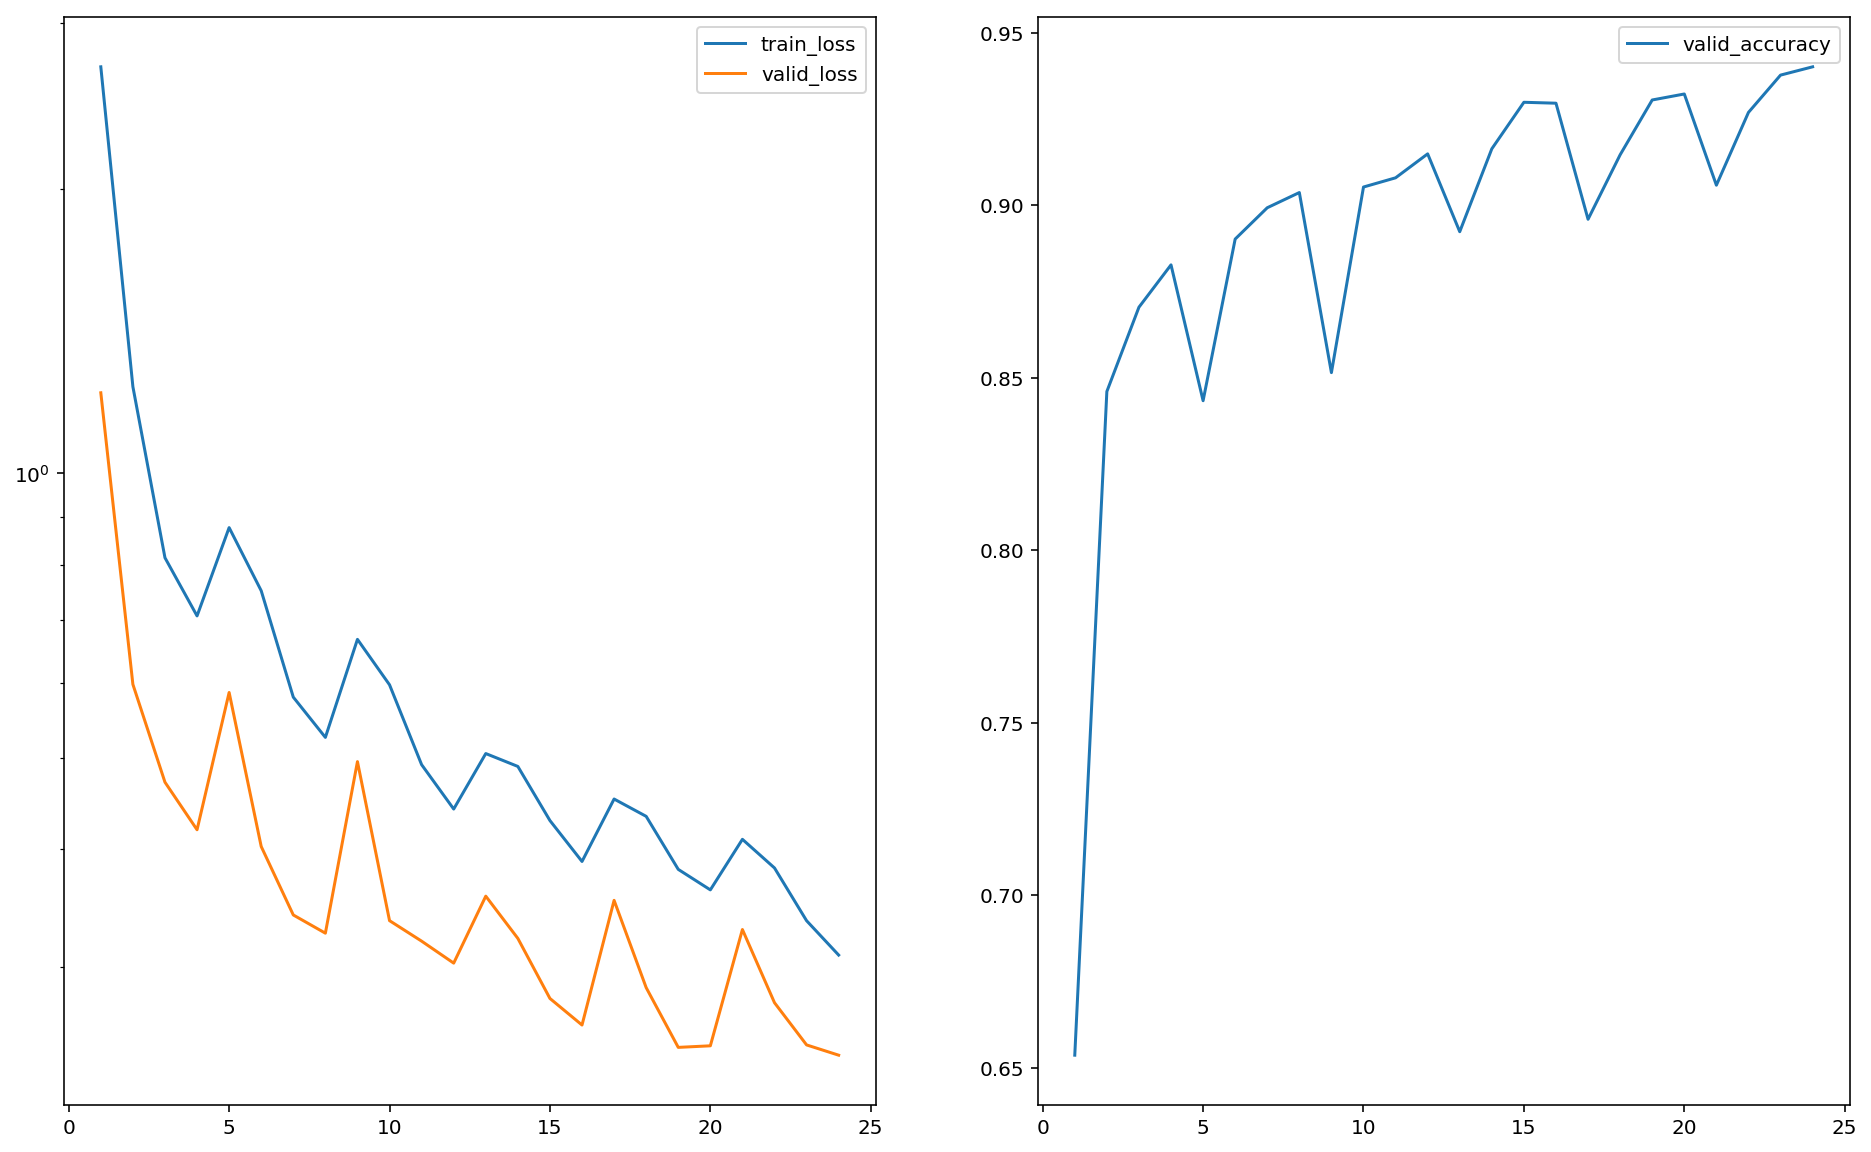

In [13]:
plot_performance_curves(perf_report)

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [14]:
# TODO: Do validation on the test set
accuracy = accuracy_score(model, get_device(), dataloaders['test'])
print("Test accuracy: {0:.03f}".format(accuracy))

Test accuracy: 0.908


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [15]:
def get_checkpoint_dir():
    return 'checkpoints'

if not os.path.exists(get_checkpoint_dir()):
    os.makedirs(get_checkpoint_dir())
    
# TODO: Save the checkpoint 
def checkpoint_save(filepath, model, meta, report, class_to_index):
    """ Store model description.
    """
    checkpoint = {
        'tag': 'model',
        'meta.arch': meta['arch'],
        'meta.hidden-layers': meta['hidden-layers'],
        'meta.output-size': meta['output-size'],
        'meta.dropout': meta['dropout'],
        'model.classifier.state_dict': model.classifier.state_dict(),
        'class_to_index': class_to_index,
        'perf_report': report
    }
    torch.save(checkpoint, filepath)

checkpoint_save(os.path.join(get_checkpoint_dir(), 'model.pth'), 
                model, 
                classifier_descriptor,
                perf_report,
                class_to_index())
    

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [16]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
def make_model_from_checkpoint(filepath, device):
    """ Make model from checkpoint
    
        Parameters
        ----------
        filepath: path to a file with model's checkpoint.
    """
    checkpoint = torch.load(filepath)
    model = make_model(pretrained_model_factory(checkpoint['meta.arch']), 
                       checkpoint['meta.output-size'], 
                       checkpoint['meta.hidden-layers'], 
                       checkpoint['meta.dropout'])
    model.classifier.load_state_dict(checkpoint['model.classifier.state_dict'])
    model.to(device)
    return model  

trained_model = make_model_from_checkpoint(os.path.join(get_checkpoint_dir(), 
                                                        'model.pth'),
                                          get_device())

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [17]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    # TODO: Process a PIL image for use in a PyTorch model
    
    # Resize image, keeping aspect ratio, such that 
    # smaller side of the image is set to 256 px.
    width, height = image.size
    if width > height:
        ratio = width / height
        new_w, new_h = (int(0.5 + 256*ratio), 256)
    else:
        ratio = height / width
        new_w, new_h = (256, int(0.5 + 256 * ratio))
    image.thumbnail((new_w, new_h))
    width, height = image.size

    # Crop center of the image
    crop_width, crop_height = get_crop_size()
    dx = (width - crop_width) // 2
    dy = (height - crop_height) // 2
    left, right = dx, dx + crop_width
    top, bottom = dy, dy + crop_height
    image = image.crop((left, top, right, bottom))

    np_image = np.array(image, dtype=np.float32)

    np_image /= 255.
    np_image -= get_image_mean()
    np_image /= get_image_std()
    np_image = np_image.transpose((2, 0, 1))
    return np_image

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [18]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    image = np.array(get_image_std()) * image + np.array(get_image_mean())
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    if title is not None:
        ax.set_title(title)
    ax.imshow(image)
    
    return ax

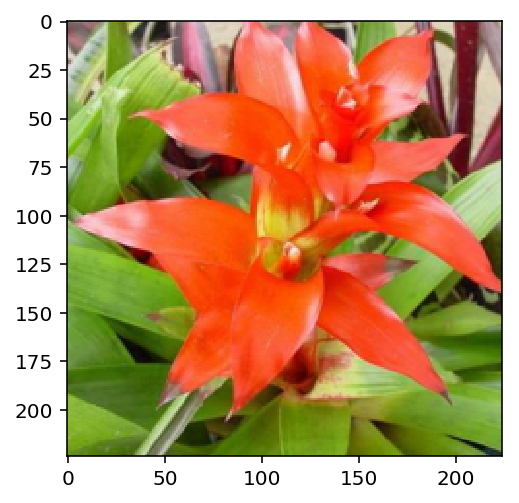

In [19]:
image = Image.open('flowers/test/99/image_07874.jpg')
np_image = process_image(image)
imshow(torch.tensor(np_image))

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [20]:
def predict(image_path, model, device, topk=5):
    """
        Predict the class (or classes) of an image using a trained deep learning model.        
        Return pair (topk-probability, topk-category)
    """
    index_to_class = {idx: cls for cls, idx in class_to_index().items()}
    model.eval()
    with torch.no_grad():
        image = torch.tensor(process_image(Image.open(image_path)))
        image = image.reshape((1, 3, 224, 224))
        image = image.to(device)
        y_hat = model.forward(image)
        estimate = torch.exp(y_hat)
    estimate = estimate.to('cpu').numpy()
    index = np.argsort(estimate, axis=1)[0][-5:][::-1]
    probs = estimate[0][index]
    return probs, [index_to_class[x] for x in index]

In [21]:
probs, classes = predict('flowers/test/1/image_06764.jpg', trained_model, get_device())
print("Probability: {}".format(probs))
print("Classes: {}".format(classes))


Probability: [9.9986273e-01 7.3928648e-05 3.2300668e-05 7.2927246e-06 7.0301057e-06]
Classes: ['1', '97', '55', '26', '95']


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [22]:
# TODO: Display an image along with the top 5 classes
def plot_image_probs(model, device, class_to_name, image_path):
    """
        - Display image
        - Plot the probabilities for the top 5 classes as a bar graph.
    """
    parts = image_path.split('/')
    img_class = parts[-2]
    
    image = torch.tensor(process_image(Image.open(image_path)))

    # Display input image
    fig, (ax1, ax2) = plt.subplots(figsize=(8,13), nrows=2, ncols=1)
    imshow(image, ax1, class_to_name[img_class])

    # Plot probabilities for 5 top classes. 
    probs, classes = predict(image_path, model, device, topk=5)

    labels = [class_to_name[k] for k in classes]
    y_pos = np.arange(len(labels))
    ax2.barh(y_pos, probs)
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(labels)
    ax2.invert_yaxis()
    plt.show()

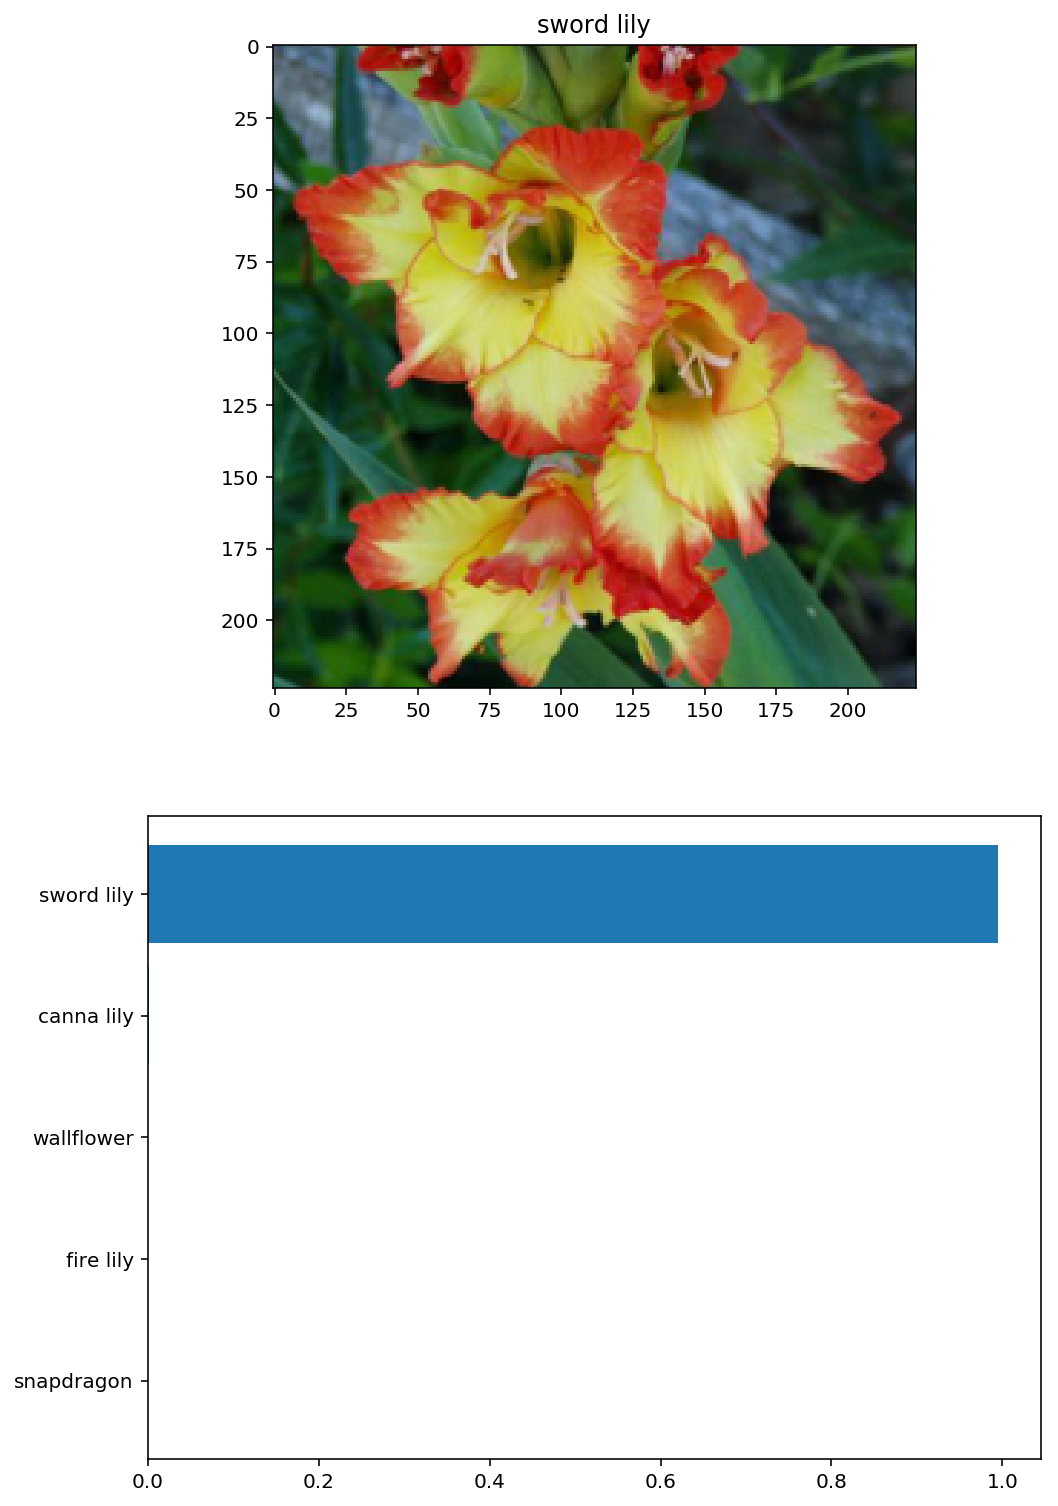

In [23]:
plot_image_probs(trained_model, get_device(), category_to_name(), 'flowers/test/43/image_02370.jpg')